In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
from datetime import datetime

from collections import Counter
import itertools

from math import comb, ceil
import random
import string

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

In [2]:
def init_association_matrix(belief_network, propositions = ['A','B','C','D']):
    
    propositions_w_sign = ["+"+p for p in propositions] + ["-"+p for p in propositions] # add the signs

    propositions_w_sign = sorted(propositions_w_sign, key=lambda x: x[1]) # sort by proposition, not sign

    association_matrix = pd.DataFrame(index=propositions_w_sign,  # create the association matrix
                                      columns=propositions_w_sign).fillna(0)

    for e in belief_network.edges(): # fill up 
        for s in [*itertools.product(['+','-'],['+','-'])]:
            association_matrix[f'{s[0]}{e[0]}'][f'{s[1]}{e[1]}'] = 1
            association_matrix[f'{s[0]}{e[1]}'][f'{s[1]}{e[0]}'] = 1

    return association_matrix

In [3]:
def init_beliefs(propositions):
    
    beliefs = np.random.uniform(-1, 1, size=len(propositions))
    beliefs = {e:b for e,b in zip(sorted(propositions), beliefs)}
    
    return beliefs

In [4]:
def bayesian(e1, e2, association_matrix):
    
    evidence = association_matrix[f'-{e2[1]}'].sum() + association_matrix[f'+{e2[1]}'].sum()
    joint_1 = association_matrix[f'+{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'-{e2[1]}'][f'-{e1[1]}']
    joint_2 = association_matrix[f'-{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'+{e2[1]}'][f'-{e1[1]}']
    
    likelihood_pos_rel = joint_1/evidence
    likelihood_neg_rel = joint_2/evidence
    
    return likelihood_pos_rel, likelihood_neg_rel

In [5]:
def infer_relationship(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    likelihood_pos_rel, likelihood_neg_rel = bayesian(e1, e2, association_matrix)
    
    if likelihood_pos_rel > likelihood_neg_rel:
        return 1
    else:
        return -1

In [6]:
def energy(message_to_convey, beliefs, relationship):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    return - beliefs[e1[1]]*beliefs[e2[1]]*relationship

In [7]:
def energy_comprehensive(message_to_convey, beliefs, association_matrix, belief_network):
    
    energy_sum = 0

    e2 = message_to_convey['e2']
    neighbors = [*belief_network.neighbors(e2[1])]

    for e1 in neighbors:

        message_to_convey = {'e1':f"+{e1}", 'e2':e2}

        relationship = infer_relationship(message_to_convey = message_to_convey, 
                                          association_matrix = association_matrix)

        e = energy(message_to_convey = message_to_convey, beliefs = beliefs, relationship = relationship)

        denominator = association_matrix[f"-{e2[1]}"].sum() + association_matrix[f"+{e2[1]}"].sum()
        nominator = association_matrix[f"-{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"-{e2[1]}"][f"+{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"+{e1}"].sum()
        weight = nominator / denominator

        energy_sum += e * weight

    return energy_sum

In [8]:
def update_belief(e1, beliefs):
    
    update_term = np.random.normal() # get an update term randomly
    
    beliefs_new = beliefs.copy() # make a copy of beliefs
    
    beliefs_new[e1[1]] = beliefs_new[e1[1]] + update_term # update the belief
    
    if beliefs_new[e1[1]] > 1:
        beliefs_new[e1[1]] = 1
        
    if beliefs_new[e1[1]] < -1:
        beliefs_new[e1[1]] = -1
    
    return beliefs_new

In [9]:
def update_association_matrix(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    association_matrix[e2][e1] += 1
    association_matrix[e1][e2] += 1

In [10]:
def init_agents(belief_network, n_agents = 2):
    
    propositions = [*belief_network.nodes()]
    
    agents = {}
    
    for a in range(n_agents):
        agents[a] = {}
        agents[a]['association_matrix'] = init_association_matrix(belief_network, propositions)
        agents[a]['beliefs'] = init_beliefs(propositions)
    
    return agents

In [11]:
def deduce_message_to_convey(beliefs_to_convey, agent_beliefs):
    
    message_to_convey = {}
    
    for i, b in enumerate(beliefs_to_convey):
        if np.sign(agent_beliefs[beliefs_to_convey[i]]) == -1:
            message_to_convey[f"e{i+1}"] = f"-{beliefs_to_convey[i]}"
        else:
            message_to_convey[f"e{i+1}"] = f"+{beliefs_to_convey[i]}"
    
    return message_to_convey

In [12]:
def optimal_clustering(beliefs, n_agents):
    
    silhouettes = []
    n_clusters = [*range(2,n_agents)]

    for k in n_clusters:
        clustering = KMeans(n_clusters=k, n_init = 'auto').fit(beliefs)
        silhouettes.append(silhouette_score(beliefs, clustering.labels_))
    
    return n_clusters[np.argmax(silhouettes)], silhouettes[np.argmax(silhouettes)]

def evaluatory_agreement(beliefs):
    
    pref_corr = pd.DataFrame(beliefs).T.corr()
    pref_corr = pref_corr.to_numpy()
    pref_corr = pref_corr[np.triu_indices_from(pref_corr, k=1)]
    
    return pref_corr

def interpretative_agreement(propositions, agents):
    
    proposition_combinations = [*itertools.combinations(propositions, 2)]

    posteriors_all = []
    for matrix in [v['association_matrix'] for v in agents.values()]:
        posteriors = []
        for p1, p2 in proposition_combinations:
            posterior_pos, posterior_neg = bayesian(f'+{p1}', f'+{p2}', matrix)
            posteriors.append(posterior_pos)
            posteriors.append(posterior_neg)

        posteriors_all.append(posteriors)

    interpretative_dist = pairwise_distances(np.array(posteriors_all), metric='euclidean')

    interpretative_dist = interpretative_dist[np.triu_indices_from(interpretative_dist, k=1)]
    
    return interpretative_dist

# Create Belief Networks

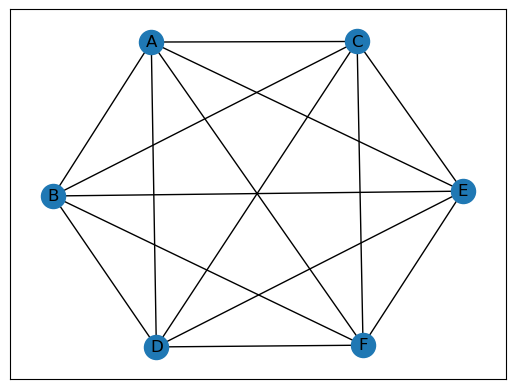

In [13]:
n_beliefs = 6
m = comb(n_beliefs,2)

is_connected = False # initialize the belief network
while is_connected == False:
    bn1 = nx.gnm_random_graph(n=n_beliefs, m = m)
    if nx.number_of_selfloops(bn1) == 0:
        is_connected = nx.is_connected(bn1)

propositions = list(string.ascii_uppercase[:n_beliefs]) # get the proposition names from the alphabet

bn1 = nx.relabel_nodes(bn1, {n:propositions[n] for n in bn1.nodes()}) # relabel the nodes with letters from the alphabet

nx.draw_networkx(bn1) # draw the belief network

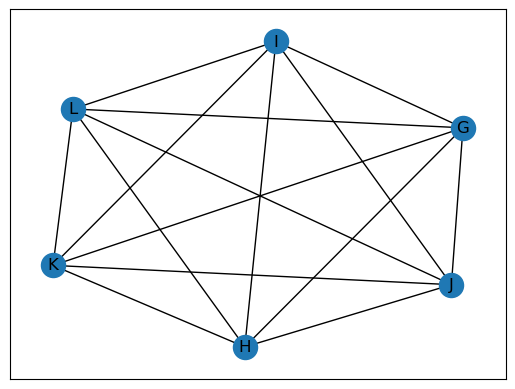

In [14]:
bn2 = bn1.copy()
bn2 = nx.relabel_nodes(bn2,{l1:l2 for l1,l2 in zip([*bn1.nodes],string.ascii_uppercase[len(bn1):len(bn1)+len(bn2)])})
nx.draw_networkx(bn2)

#### Compose networks

In [15]:
def compose_networks(bn1, bn2, n_nodes_to_connect = 1):
    
    edges_to_add = []

    for c in range(n_nodes_to_connect):
        pair_exists = True
        while pair_exists:
            pair = (np.random.choice([*bn1.nodes()]), np.random.choice([*bn2.nodes()]))
            if pair not in edges_to_add:
                pair_exists = False

        edges_to_add.append(pair)

    bn_composed = nx.compose(bn1,bn2)
    propositions = [*bn_composed.nodes()]

    for edge in edges_to_add:
        bn_composed.add_edge(edge[0], edge[1])

    return bn_composed

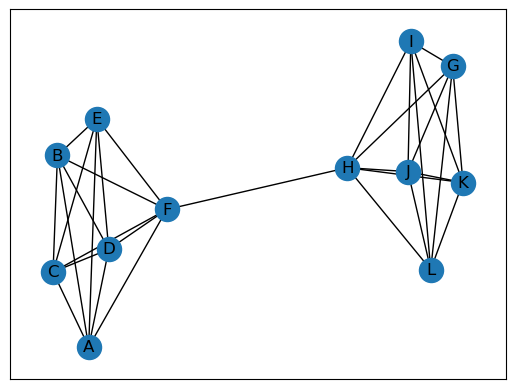

In [68]:
nx.draw_networkx(compose_networks(bn1, bn2, n_nodes_to_connect = 1))

# Simulation of 2 Agents

In [115]:
n_agents = 2

agents = init_agents(bn_composed, propositions, n_agents)

simulation_steps = [*range(5000)]

for t in simulation_steps:
    
    i = np.random.choice([0,1]) # choose an agent to be the sender
    j = list(set([0,1]) - set([i]))[0] # the other one will be the receiver
    
    b1 = np.random.choice([*bn_composed.nodes()])
    b2 = np.random.choice([*bn_composed.neighbors(b1)])
    beliefs_to_convey = [b1,b2]
    
    message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
    update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
    
    relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
    
    beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
    
    energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = agents[j]['beliefs'], 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = beliefs_new, 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    if energy_t_plus_1 < energy_t:
        agents[j]['beliefs'] = beliefs_new

In [191]:
((agents[0]['association_matrix']['+F']['+B'].sum()+agents[0]['association_matrix']['-F']['+B'].sum()) + (agents[0]['association_matrix']['+F']['-B'].sum()+agents[0]['association_matrix']['-F']['-B'].sum())) / (agents[0]['association_matrix']['+F'].sum()+agents[0]['association_matrix']['-F'].sum())


0.23414634146341465

In [171]:
message_to_convey = {'e1': '+B', 'e2': '+C'}

energy_comprehensive(message_to_convey = message_to_convey,
                     beliefs = agents[0]['beliefs'], 
                     association_matrix = agents[1]['association_matrix'],
                     belief_network = bn1)

+C
['A', 'F']
A 0.4728682170542636
F 0.5271317829457365


-1.0

In [173]:
[*bn1.neighbors('C')]

['A', 'F']

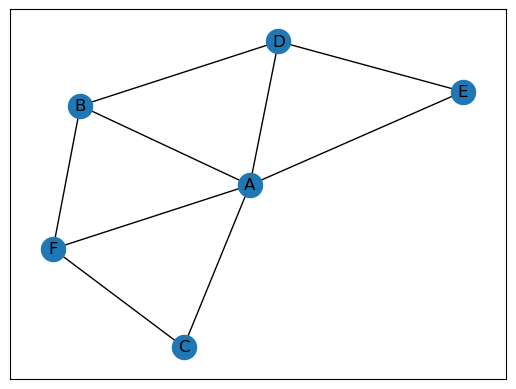

In [166]:
nx.draw_networkx(bn1)

# Simulation of Multiple Agents

In [27]:
def simulate_multiple_agents(bn1, bn2, n_nodes_to_connect):
    
    n_agents = 20

    bn_composed = compose_networks(bn1=bn1, bn2=bn2, n_nodes_to_connect = n_nodes_to_connect)
    propositions = [*bn_composed.nodes()]
    agents = init_agents(bn_composed, n_agents)
    agent_list = [*agents.keys()]
    node_list = [*bn_composed.nodes()]
    last_step = 200000

    simulation_steps = [*range(last_step+1)]

    track = {}

    for t in tqdm(simulation_steps):
        
        i,j = np.random.choice(agent_list, 2, replace=False) # choose an agent to be the sender and the other one will be the receiver
        
        b1 = np.random.choice(node_list)
        b2 = np.random.choice([*bn_composed.neighbors(b1)])
        beliefs_to_convey = [b1,b2]
        
        message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
        update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
        
        relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
        
        beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
        
        energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                        beliefs = agents[j]['beliefs'], 
                                        association_matrix = agents[j]['association_matrix'],
                                        belief_network = bn_composed)
        
        energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                        beliefs = beliefs_new, 
                                        association_matrix = agents[j]['association_matrix'],
                                        belief_network = bn_composed)

        if energy_t_plus_1 < energy_t:
            agents[j]['beliefs'] = beliefs_new

        # keep track of the evolution of the agents
        if t % 1000 == 0:
            track[t] = {}
            
            beliefs = np.array([[*a['beliefs'].values()] for a in agents.values()])
            
            # Count of unique belief networks
            unique_belief_networks = np.unique(beliefs,axis=0)
            track[t]['count_unique_belief_networks'] = len(unique_belief_networks)
            
            # Number of clusters
            #cluster_count, silhouette = optimal_clustering(beliefs, n_agents)
            #track[t]['cluster_count'] = cluster_count
            #track[t]['silhouette_score'] = silhouette
            
            # Preference congruence and similarity
            pref_corr = evaluatory_agreement(beliefs)
            track[t]['preference_congruence'] = np.abs(pref_corr).mean()
            track[t]['preference_similarity'] = pref_corr.mean()
            
            # Computing evaluatory agreement
            interpretative_dist = interpretative_agreement(propositions, agents)
            track[t]['interpretative_dist'] = np.mean(interpretative_dist)

            # Stop if everybody has either -1 or +1 only
            if len(np.unique(unique_belief_networks))==2:
                track[t]['belief_networks'] = beliefs
                break

            if t == last_step:
                track[t]['belief_networks'] = beliefs

    return track

In [35]:
max_nodes_to_connect = 6
repetition = 100

n_nodes_to_connect = list(np.array([[i]*repetition for i in range(1,max_nodes_to_connect+1)]).flatten())
simulation_count = repetition * len(np.unique(n_nodes_to_connect))
params = [*zip([bn1] * simulation_count, [bn2] * simulation_count, n_nodes_to_connect)]

In [36]:
pool = mp.Pool(processes=32)
results = pool.starmap(simulate_multiple_agents, params)
pool.close()

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

with open(f'../data/results_{dt_string}.pkl', 'wb') as f:
    pickle.dump(results, f)

 44%|████▍     | 88000/200001 [02:15<02:52, 650.58it/s]


In [33]:
with open('../data/results.pkl', 'rb') as f:
    check = pickle.load(f)

In [124]:
i = 240
last_step = [*results[i].keys()][-1]
np.unique(results[i][last_step]['belief_networks'], axis=0)

array([[-1.        , -1.        , -1.        , -1.        ,  1.        ,
         1.        ,  1.        , -1.        , -1.        ,  1.        ,
         1.        , -1.        ],
       [-1.        , -0.26415881,  0.66774991,  0.35666204, -1.        ,
        -1.        ,  1.        , -1.        , -1.        ,  1.        ,
         1.        , -1.        ],
       [-1.        ,  1.        ,  1.        , -0.24817969, -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  1.        ],
       [-1.        ,  1.        ,  1.        ,  0.70441329, -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  1.        ],
       [-1.        ,  1.        ,  1.        ,  0.75044612, -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  1.        ],
       [-1.        ,  1.        ,  1.        ,  0.75109081, -1.        ,
        -1.        ,  

(array([19.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0., 17.]),
 array([ 2. ,  3.8,  5.6,  7.4,  9.2, 11. , 12.8, 14.6, 16.4, 18.2, 20. ]),
 <BarContainer object of 10 artists>)

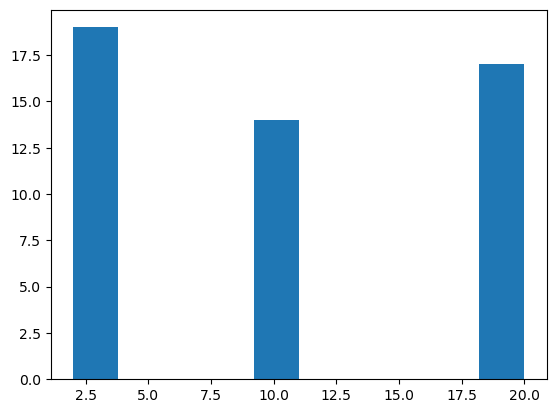

In [125]:
plt.hist([[v['count_unique_belief_networks'] for v in r.values()][-1] for r in results[250:300]])

In [140]:
results[200]

{0: {'count_unique_belief_networks': 20,
  'preference_congruence': 0.014492408599330443,
  'preference_similarity': 0.23813750164905179,
  'evaluatory_agreement': 0.004517541621868851},
 1000: {'count_unique_belief_networks': 20,
  'preference_congruence': 0.025577021227311984,
  'preference_similarity': 0.23210991618448365,
  'evaluatory_agreement': 0.2966852820781021},
 2000: {'count_unique_belief_networks': 20,
  'preference_congruence': 0.014661111682222096,
  'preference_similarity': 0.24920039090250456,
  'evaluatory_agreement': 0.3226307203604926},
 3000: {'count_unique_belief_networks': 20,
  'preference_congruence': 0.03278278868095565,
  'preference_similarity': 0.26201404488229657,
  'evaluatory_agreement': 0.33329839223134583},
 4000: {'count_unique_belief_networks': 20,
  'preference_congruence': 0.031324562997085185,
  'preference_similarity': 0.26386352219955295,
  'evaluatory_agreement': 0.3220387432451397},
 5000: {'count_unique_belief_networks': 20,
  'preference_con

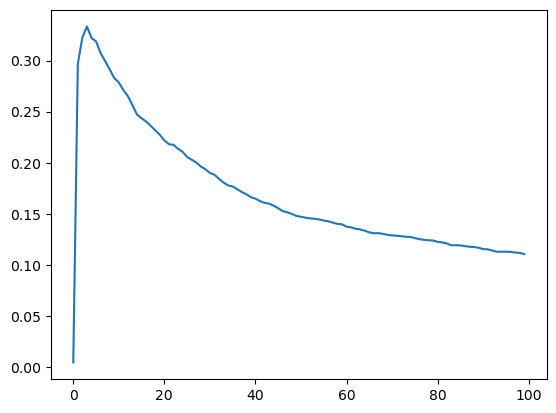

In [134]:
plt.plot([v['evaluatory_agreement'] for v in results[200].values()])

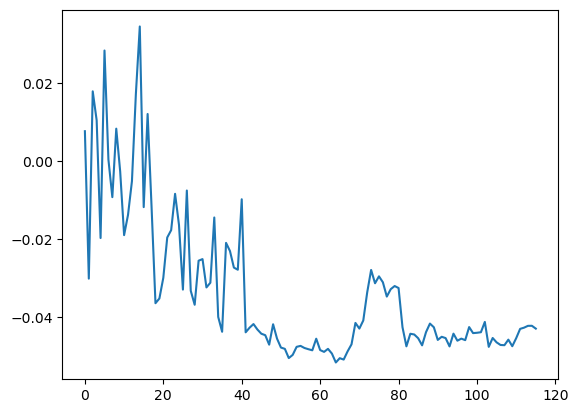

In [162]:
plt.plot([v['preference_congruence'] for v in results[80].values()])

In [151]:
plt.plot([v['preference_congruence'] for v in track.values()])

NameError: name 'track' is not defined